# Logic Gate Task

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

import datetime
import numpy as np
import os
import scipy.stats
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt

# Import n-task
from keras_context.switches import TdErrorSwitch
from keras_context.callbacks import ContextLogger
from keras_context.flags import Verbosity
from keras_context.layers import Context
from keras_context.models import ContextModel
from keras_context.training import train, evaluate
from keras_context.utils import set_seed
import numpy as np

___

## Experimentation Setup

The following cells here build everything up for the experiments to execute

### Dataset Creation

The following cell creates the base dataset with all of the gates.

In [31]:
# Define the gates explicitly
gates = {
    "xor":      [0, 1, 1, 0],
    "xnor":     [1, 0, 0, 1],
    "and":      [0, 0, 0, 1],
    "or":       [0, 1, 1, 1],
    "nor":      [1, 0, 0, 0],
    "nand":     [1, 1, 1, 0],
    "custom_1": [1, 0, 1, 0],
    "custom_2": [0, 1, 0, 1]
}

# Build the labels used for `y_train` to work with the `train` convenience function
y_labels = [np.array([[i] for i in gate]) for gate in gates.values()]

# The inputs for each of the gates
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

### Model Architecture and Creation

The following function creates a new instance of the model for each experiment. The hyperparameters are provided as arguments. The model summary is also displayed.

In [32]:
def create_model(tag, optimizer, num_contexts, max_contexts=0, switch_threshold=0.0, add_threshold=0.0, summary=True):
    # Model architecture
    inp = Input((2,))
    x = Dense(hrr_size, activation="relu")(inp)
    x = Context(
        num_contexts,
        TdErrorSwitch(learn_rate=0.5, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold),
        name="Gate_Context"
    )(x)
    x = Dense(1, activation="sigmoid")(x)
    model = ContextModel(inputs=inp, outputs=x)
    
    # Compile the model together with binary_crossentropy loss
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.BinaryAccuracy()
        ]
    )
    
    # Display the model summary
    if summary:
        model.summary()
    
    return model

___

## Experimentation

### 1. Static n-task: (XOR, XNOR)

The following experiments demonstrates the model successfully learning two separate logic gates.

In [9]:
TAG = "static-2-gate"

#### Dataset

In [10]:
y_train = y_labels[:2]

#### Seeding

In [11]:
set_seed(5)

#### Model Creation

In [12]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = len(y_train)
switch_threshold = -0.02

# Create the model
model = create_model(TAG, optimizer, num_contexts=len(y_train), switch_threshold=switch_threshold)

Model: "context_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               260       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 773
Trainable params: 513
Non-trainable params: 260
_________________________________________________________________


#### Training

In [13]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = Verbosity.Contexts

logger = ContextLogger()
callbacks = [logger]

# Train the model
%time _, _, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)


[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0
CPU times: user 1.12 s, sys: 46.9 ms, total: 1.17 s
Wall time: 1.07 s


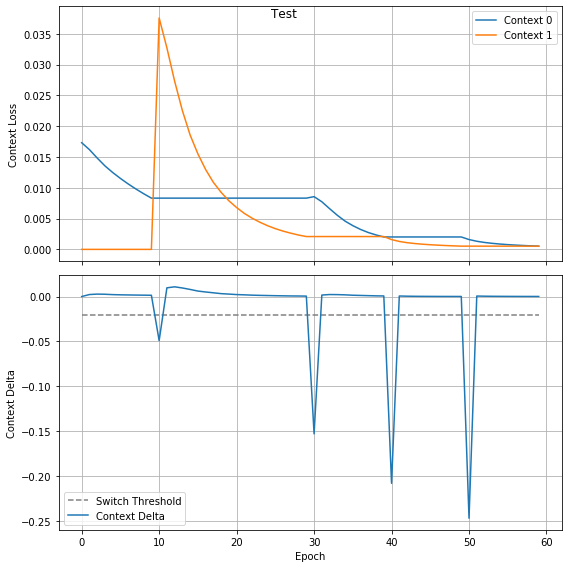

In [14]:
logger.plot(figsize=(8,8), title="Test")

#### Evaluation

In [21]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.04025948],
       [0.96960604],
       [0.96226275],
       [0.03171104]], dtype=float32)
array([[0.97145987],
       [0.02444988],
       [0.03115296],
       [0.9637778 ]], dtype=float32)
CPU times: user 312 ms, sys: 15.6 ms, total: 328 ms
Wall time: 318 ms


[{'loss': 0.03566252812743187, 'binary_accuracy': 1.0},
 {'loss': 0.030563028529286385, 'binary_accuracy': 1.0}]

___

### 2. Dynamic n-task: (XOR, XNOR)

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

In [28]:
TAG = "dynamic-2-gate"

#### Dataset

In [29]:
y_train = y_labels[:2]

#### Seeding

In [30]:
set_seed(5)

#### Model Creation

In [31]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = 1
max_contexts     = len(y_train)
switch_threshold = -0.02
add_threshold    = -0.04

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold)

Model: "context_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               260       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 773
Trainable params: 513
Non-trainable params: 260
_________________________________________________________________


#### Training

In [32]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = Verbosity.Contexts

logger = ContextLogger()
callbacks = [logger]

# Benchmark the model
%time _, _, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)


[Gate_Context] Adding context 1

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0
CPU times: user 1.2 s, sys: 266 ms, total: 1.47 s
Wall time: 1.09 s


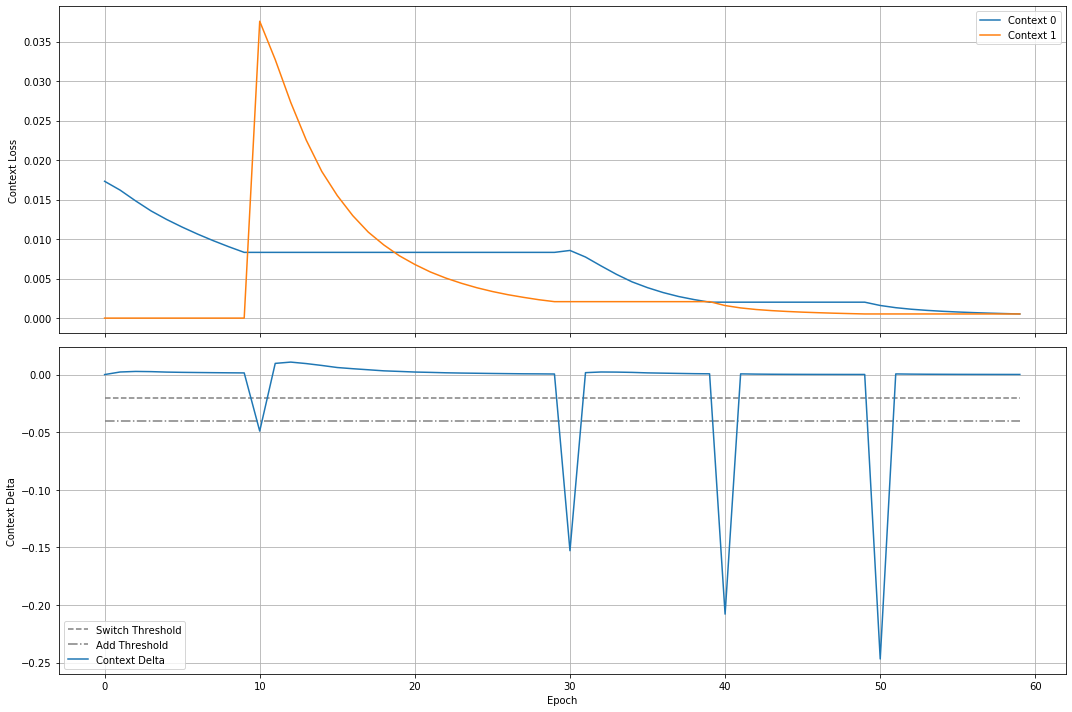

In [33]:
logger.plot(figsize=(15,10))

#### Evaluation

In [34]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.04025948],
       [0.96960604],
       [0.96226275],
       [0.03171104]], dtype=float32)
array([[0.97145987],
       [0.02444988],
       [0.03115296],
       [0.9637778 ]], dtype=float32)
CPU times: user 312 ms, sys: 46.9 ms, total: 359 ms
Wall time: 350 ms


[{'loss': 0.03566252812743187, 'binary_accuracy': 1.0},
 {'loss': 0.030563028529286385, 'binary_accuracy': 1.0}]

___

### 3. Static n-task: All Gates

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

In [44]:
TAG = "static-all-gates"

#### Dataset

In [45]:
y_train = y_labels[:]

#### Seeding

In [46]:
set_seed(10)

#### Model Creation

In [47]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 256
num_contexts     = len(y_train)
switch_threshold = -0.02

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, switch_threshold=switch_threshold)

Model: "context_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
Gate_Context (Context)       (None, 256)               2058      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 3,083
Trainable params: 1,025
Non-trainable params: 2,058
_________________________________________________________________


#### Training

In [48]:
cycles     = 4
epochs     = 50
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = 0 # Verbosity.Contexts

logger = ContextLogger()
callbacks = [logger]

# Benchmark the model
%time history, evals, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

CPU times: user 24.5 s, sys: 2.86 s, total: 27.4 s
Wall time: 22 s


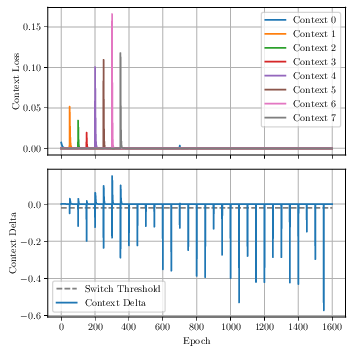

In [49]:
logger.plot(figsize=(5,5), savefile="graphs/gates_static.pgf")

#### Evaluation

In [50]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[9.7808242e-04],
       [9.9937528e-01],
       [9.9916089e-01],
       [1.4414489e-03]], dtype=float32)
array([[9.9885857e-01],
       [6.0823560e-04],
       [1.4194548e-03],
       [9.9896598e-01]], dtype=float32)
array([[1.3930965e-05],
       [1.8936694e-03],
       [1.6820431e-04],
       [9.9999940e-01]], dtype=float32)
array([[6.6667795e-04],
       [9.9947953e-01],
       [9.9948859e-01],
       [9.9989837e-01]], dtype=float32)
array([[9.9974006e-01],
       [1.7535090e-03],
       [2.0153821e-03],
       [2.7158856e-04]], dtype=float32)
array([[9.9971354e-01],
       [9.9867600e-01],
       [9.9873412e-01],
       [8.4257126e-04]], dtype=float32)
array([[9.9971092e-01],
       [4.6984511e-05],
       [9.9954426e-01],
       [4.4375276e-05]], dtype=float32)
array([[2.7868152e-04],
       [9.9934024e-01],
       [6.7395595e-05],
       [9.9924916e-01]], dtype=float32)
CPU times: user 594 ms, sys: 93.8 ms, total: 688 ms
Wall time: 683 ms


[{'loss': 0.0009713891195133328, 'binary_accuracy': 1.0},
 {'loss': 0.0010513985762372613, 'binary_accuracy': 1.0},
 {'loss': 0.0005195346311666071, 'binary_accuracy': 1.0},
 {'loss': 0.00045019283425062895, 'binary_accuracy': 1.0},
 {'loss': 0.0010760144796222448, 'binary_accuracy': 1.0},
 {'loss': 0.0009302362450398505, 'binary_accuracy': 1.0},
 {'loss': 0.00020906885038129985, 'binary_accuracy': 1.0},
 {'loss': 0.0004393107956275344, 'binary_accuracy': 1.0}]

___

### 4. Dynamic n-task: All Gates

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

**NOTE:** The results to this task require some further analysis. I'm not certain what exactly the spikes really mean here, especially since they're displaying positive context-loss deltas. Also the fact that the first few tasks are initially learned using the very first context, and only later are things learned in their appropriate contexts.

In [53]:
TAG = "dynamic-all-gates"

#### Dataset

In [54]:
y_train = y_labels[:]

#### Seeding

In [55]:
set_seed(10)

#### Model Creation

In [56]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 256
num_contexts     = 1
max_contexts     = len(y_train)
switch_threshold = -0.02
add_threshold    = -0.08

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold)

Model: "context_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               768       
_________________________________________________________________
Gate_Context (Context)       (None, 256)               2058      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 3,083
Trainable params: 1,025
Non-trainable params: 2,058
_________________________________________________________________


#### Training

In [57]:
cycles     = 4
epochs     = 50
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

# verbose = Verbosity.Contexts
verbose = 0

logger = ContextLogger()
callbacks = [logger]

# Benchmark the model
%time history, evals, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

CPU times: user 23.7 s, sys: 2.7 s, total: 26.4 s
Wall time: 20.8 s


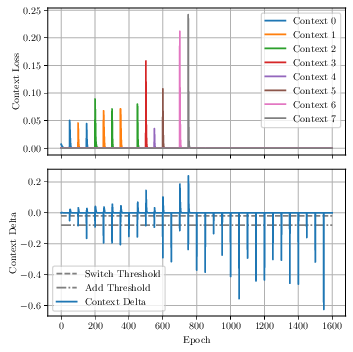

In [58]:
logger.plot(figsize=(5,5), savefile="graphs/gates_dynamic.pgf")

#### Evaluation

In [59]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.00155857],
       [0.9991865 ],
       [0.99880326],
       [0.0019649 ]], dtype=float32)
array([[9.9856591e-01],
       [8.7004900e-04],
       [1.5020072e-03],
       [9.9851644e-01]], dtype=float32)
array([[3.4132600e-04],
       [2.8317869e-03],
       [1.4919043e-03],
       [9.9843347e-01]], dtype=float32)
array([[7.4732304e-04],
       [9.9816859e-01],
       [9.9830604e-01],
       [9.9872130e-01]], dtype=float32)
array([[9.9855721e-01],
       [1.2702346e-03],
       [1.1161864e-03],
       [7.6925755e-04]], dtype=float32)
array([[9.9902332e-01],
       [9.9822146e-01],
       [9.9935126e-01],
       [8.9022517e-04]], dtype=float32)
array([[9.9966884e-01],
       [4.6193600e-04],
       [9.9930632e-01],
       [1.1983812e-03]], dtype=float32)
array([[1.3881922e-04],
       [9.9997413e-01],
       [3.4874029e-05],
       [9.9993730e-01]], dtype=float32)
CPU times: user 500 ms, sys: 46.9 ms, total: 547 ms
Wall time: 546 ms


[{'loss': 0.0013844938948750496, 'binary_accuracy': 1.0},
 {'loss': 0.0013233473291620612, 'binary_accuracy': 1.0},
 {'loss': 0.0015595033764839172, 'binary_accuracy': 1.0},
 {'loss': 0.0013889356050640345, 'binary_accuracy': 1.0},
 {'loss': 0.0011503188870847225, 'binary_accuracy': 1.0},
 {'loss': 0.0010742157464846969, 'binary_accuracy': 1.0},
 {'loss': 0.000671542133204639, 'binary_accuracy': 1.0},
 {'loss': 6.555423169629648e-05, 'binary_accuracy': 1.0}]

___

### 5. Static Benchmark

This runs the static n-task logic gate experiment some number of times and calculates various statistics regarding the loss over time.

> ./logic_gate_task.py \<num_seeds> \<num_threads> \<num_training_cycles> \<num_training_epochs>


In [185]:
%time !python3 ./logic_gate_task.py 100 12 8 50

CPU times: user 36.3 s, sys: 12.4 s, total: 48.8 s
Wall time: 50min 37s


In [66]:
# Load the model results
with open("data/logic_gates.dat", 'rb') as f:
    data = pickle.load(f)

In [68]:
# Organize the data
results = {}
for key in sorted(data.keys()):
    seed, num_contexts = key
    if num_contexts not in results:
        results[num_contexts] = []
    results[num_contexts].append(np.mean([[task["binary_accuracy"] for task in cycle] for cycle in data[key][1]], axis=1))

In [69]:
# Convert to Numpy arrays
for key in results:
    results[key] = np.array(results[key])

In [71]:
results[8][:,-1] # [num_atrs, seed, cycle_index]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
boxplot_data = [results[key][:,-1] for key in results]

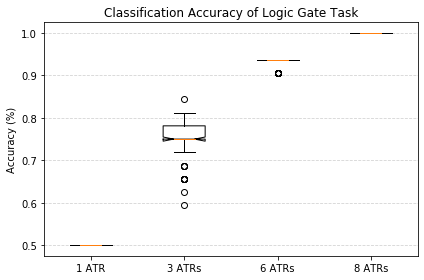

In [27]:
%matplotlib inline
fig, ax = plt.subplots()
labels = ["1 ATR", "3 ATRs", "6 ATRs", "8 ATRs"]
x_pos = np.arange(1, len(labels)+1)
ax.grid(True, axis='y', linestyle='--', color='lightgrey', zorder=0)
# for x, label in enumerate(labels):
ax.boxplot(boxplot_data, notch=True, zorder=3)
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("Classification Accuracy of Logic Gate Task")
plt.tight_layout()
plt.savefig("graphs/accuracy.pgf")